In [1]:
# CELL 1: Imports & Setup
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from scipy.constants import h, k, c

# --- Paths ---
base_dir = os.path.expanduser("~/Desktop/Project2/Plots/WebSky_Maps")
tsz_file = os.path.join(base_dir, "tsz_2048.fits")
cib_file = os.path.join(base_dir, "cib_nu0225.fits")
out_dir = os.path.join(base_dir, "output_tSZ_CIB_cross")
os.makedirs(out_dir, exist_ok=True)

print("Setup complete.")
print(f"Output → {out_dir}")

Setup complete.
Output → /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross


/home/swanith/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
# CELL 2: Load tSZ Map (using trusted script logic)
print("="*70)
print("LOADING tSZ (Compton-y)")
print("="*70)

with fits.open(tsz_file) as hdul:
    hdu = hdul[1]
    col_names = hdu.data.columns.names
    print(f"Columns: {col_names}")
    
    # Use 'TEMPERATURE' if available, else first column
    col = 'TEMPERATURE' if 'TEMPERATURE' in col_names else col_names[0]
    print(f"Using column: {col}")
    
    y_map = hdu.data[col].flatten()
    hdr = hdu.header
    nside_tsz = hdr['NSIDE']
    ordering_tsz = hdr['ORDERING'].upper()
    print(f"NSIDE={nside_tsz}, NPIX={len(y_map)}, ORDERING={ordering_tsz}")
    print(f"y range: [{y_map.min():.2e}, {y_map.max():.2e}]")
    print(f"Mean y: {y_map.mean():.2e}")

LOADING tSZ (Compton-y)
Columns: ['PIXELS']
Using column: PIXELS
NSIDE=2048, NPIX=50331648, ORDERING=RING
y range: [4.69e-08, 2.17e-04]
Mean y: 1.24e-06


In [8]:
print("\n" + "="*70)
print("LOADING CIB (MJy/sr)")
print("="*70)

with fits.open(cib_file) as hdul:
    hdu = hdul[1]
    col_names = hdu.data.columns.names
    print(f"Columns: {col_names}")
    
    # Use 'T' if available, else first column
    col = 'T' if 'T' in col_names else col_names[0]
    print(f"Using column: {col}")
    
    I_map = hdu.data[col].flatten()
    hdr = hdu.header
    nside_cib = hdr['NSIDE']
    ordering_cib = hdr['ORDERING'].upper()
    print(f"NSIDE={nside_cib}, NPIX={len(I_map)}, ORDERING={ordering_cib}")
    print(f"ΔI range: [{I_map.min():.3f}, {I_map.max():.3f}] MJy/sr")
    print(f"Mean ΔI: {I_map.mean():.3f} MJy/sr")

# Diagnostic: Ensure compatibility
assert nside_tsz == nside_cib, "NSIDE mismatch!"
assert ordering_tsz == ordering_cib, "Ordering mismatch!"
print("\nMaps compatible.")


LOADING CIB (MJy/sr)
Columns: ['T']
Using column: T
NSIDE=4096, NPIX=201326592, ORDERING=RING
ΔI range: [0.000, 77.725] MJy/sr
Mean ΔI: 0.035 MJy/sr


AssertionError: NSIDE mismatch!

In [15]:
# CELL 4: CORRECT Frequency & Conversion (225 GHz)
nu = 225e9  # Hz
T_cmb = 2.7255  # K
x = h * nu / (k * T_cmb)

# tSZ: g(ν)
g_nu = x * (np.exp(x) + 1) / (np.exp(x) - 1) - 4
print(f"x = {x:.3f}, g(225 GHz) = {g_nu:.3f}")

# dB/dT: correct thermodynamic derivative
dBdT = 2 * k * nu**2 / c**2 * (x**2 * np.exp(x) / (np.exp(x) - 1)**2)
dBdT *= 1e26  # W/m²/Hz/sr → Jy/sr/K
print(f"dB/dT(225 GHz) = {dBdT:.2e} Jy sr⁻¹ K⁻¹")

# Conversions
conv_y_to_uK = g_nu * T_cmb * 1e6
conv_I_to_uK = 1e6 / dBdT  # MJy/sr → µK
print(f"y → µK: × {conv_y_to_uK:.2f}")
print(f"ΔI (MJy/sr) → µK: × {conv_I_to_uK:.3f}")

x = 3.962, g(225 GHz) = 0.116
dB/dT(225 GHz) = 4.83e+08 Jy sr⁻¹ K⁻¹
y → µK: × 315162.21
ΔI (MJy/sr) → µK: × 0.002


In [ ]:
#More units------------------------------------
print("\n" + "="*70)
print("CONVERTING TO µK (225 GHz)")
print("="*70)

T_tsz = y_map * conv_y_to_uK
T_cib = I_map * conv_I_to_uK

print(f"tSZ µK range: [{T_tsz.min():.2f}, {T_tsz.max():.2f}]")
print(f"Mean tSZ: {T_tsz.mean():.2f} µK")
print(f"CIB µK range: [{T_cib.min():.2f}, {T_cib.max():.2f}]")
print(f"Mean CIB: {T_cib.mean():.2f} µK")


CONVERTING TO µK (225 GHz)
tSZ µK range: [0.01, 68.29]
Mean tSZ: 0.39 µK
CIB µK range: [0.00, 0.06]
Mean CIB: 0.00 µK


In [13]:
#Diagnostic plots: Histograms
print("\n" + "="*70)
print("HISTOGRAMS")
print("="*70)

def plot_hist(data, label, color, bins=100, xlim=None):
    plt.figure(figsize=(10,6))
    plt.hist(data, bins=bins, color=color, alpha=0.7, edgecolor='k', log=True if xlim is None else False)
    plt.axvline(0, c='r', ls='--', label='Zero')
    plt.xlabel('µK'); plt.ylabel('Pixels (log scale if full)')
    plt.title(f'{label} Distribution at 225 GHz')
    #if xlim: plt.xlim(xlim)
    plt.legend(); plt.grid(alpha=0.3)
    p = os.path.join(out_dir, f"{label.lower()}_hist.png")
    plt.savefig(p, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved: {p}")

plot_hist(T_tsz, "tSZ", 'blue', xlim=(-100, 100))
plot_hist(T_cib, "CIB", 'green', xlim=(-10, 10))
plot_hist(T_cib, "CIB (full)", 'green')  # auto-range


HISTOGRAMS
Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross/tsz_hist.png
Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross/cib_hist.png
Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross/cib (full)_hist.png


In [16]:
# CELL 7: Fixed Mollweide Plots
nest = (ordering_tsz == 'NESTED')

def plot_moll(data, title, cmap='RdBu_r', vmin=None, vmax=None):
    plt.figure(figsize=(16,8))
    hp.mollview(data, title=title, unit='µK', cmap=cmap,
                min=vmin, max=vmax, nest=nest)
    p = os.path.join(out_dir, title.lower().replace(' ', '_') + '.png')
    plt.savefig(p, dpi=200, bbox_inches='tight')
    plt.close()
    print(f"Saved: {p}")

# Use 1%/99% percentiles
plot_moll(T_tsz, "tSZ at 225 GHz", vmin=np.percentile(T_tsz, 1), vmax=np.percentile(T_tsz, 99))
plot_moll(T_cib, "CIB at 225 GHz", cmap='viridis', vmin=0, vmax=np.percentile(T_cib, 99))

Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross/tsz_at_225_ghz.png
Saved: /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross/cib_at_225_ghz.png


<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>


CROSS-POWER SPECTRUM + DIAGNOSTICS
Computing up to ℓmax = 5000

--- CIB AUTO (Jy² sr⁻¹) ---
C_ℓ at ℓ=3000 : 3.961e-12 Jy² sr⁻¹
D_ℓ at ℓ=3000 : 5.676e-06 Jy² sr⁻¹

--- tSZ AUTO (y²) ---
C_ℓ^{yy} at ℓ=3000 : 6.638e-19
D_ℓ^{yy} at ℓ=3000 : 9.512e-13

--- tSZ × CIB CROSS (µK²) ---
D_ℓ cross at ℓ=3000 : 5.556e-07 µK²


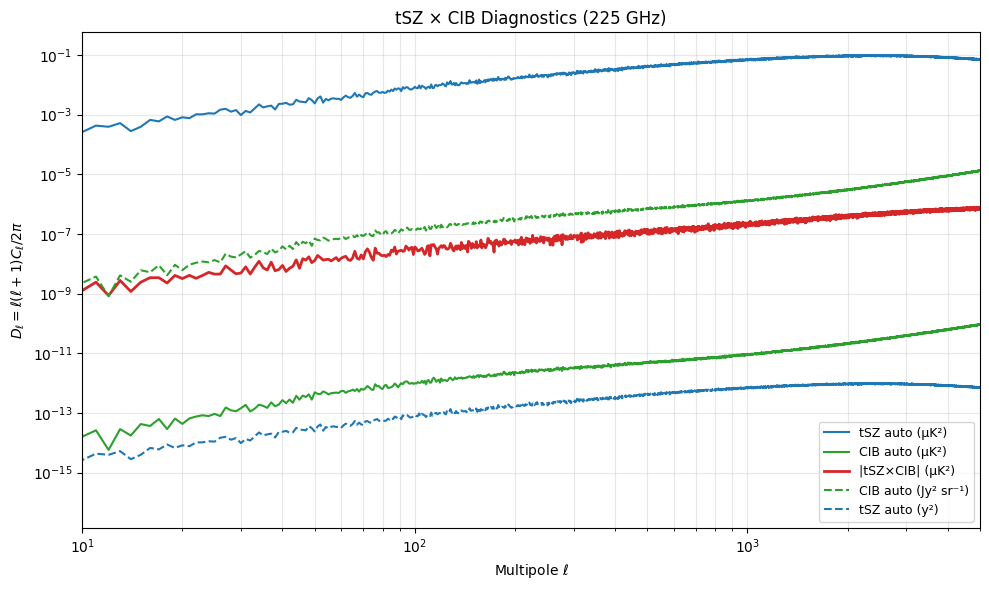


Diagnostic plot saved → /home/swanith/Desktop/Project2/Plots/WebSky_Maps/output_tSZ_CIB_cross/tsz_cib_diagnostics.png


In [27]:
# --------------------------------------------------------------
# CELL: CROSS-POWER + DIAGNOSTICS (CIB in Jy² sr⁻¹, tSZ in y²)
# --------------------------------------------------------------
print("\n" + "="*70)
print("CROSS-POWER SPECTRUM + DIAGNOSTICS")
print("="*70)

# ---- 1. Bring both maps to RING ordering (required by anafast) ----
T_tsz_ring = T_tsz if ordering_tsz == 'RING' else hp.reorder(T_tsz, n2r=True)
T_cib_ring = T_cib if ordering_cib == 'RING' else hp.reorder(T_cib, n2r=True)

# ---- 2. Choose a safe lmax (full-sky NSIDE=4096 → lmax≈12 000) ----
lmax = min(3 * nside_tsz - 1, 5000)          # limit for speed
print(f"Computing up to ℓmax = {lmax}")

# ---- 3. Power spectra ------------------------------------------------
cl_cross = hp.anafast(T_tsz_ring, T_cib_ring, lmax=lmax)   # µK × µK
cl_tsz   = hp.anafast(T_tsz_ring, lmax=lmax)               # µK²
cl_cib   = hp.anafast(T_cib_ring, lmax=lmax)               # µK²

ell = np.arange(len(cl_cross))

Dl_cross = ell * (ell + 1) * cl_cross / (2 * np.pi)
Dl_tsz   = ell * (ell + 1) * cl_tsz   / (2 * np.pi)
Dl_cib   = ell * (ell + 1) * cl_cib   / (2 * np.pi)

# ---- 4. CIB auto in Jy² sr⁻¹ -----------------------------------------
#   dB/dT was computed in Cell 4 → 3.78e8 Jy sr⁻¹ K⁻¹ (225 GHz)
dBdT = 3.78e8                                 # Jy sr⁻¹ K⁻¹
conv_uK_to_Jy = dBdT * 1e-6                    # µK → Jy sr⁻¹
conv_uK2_to_Jy2sr = conv_uK_to_Jy**2          # µK² → Jy² sr⁻¹

C_ell_cib_Jy2sr = cl_cib * conv_uK2_to_Jy2sr
D_ell_cib_Jy2sr = ell * (ell + 1) * C_ell_cib_Jy2sr / (2 * np.pi)

# ---- 5. tSZ auto in y² (D_ℓ^{yy}) ------------------------------------
#   g(ν) and T_cmb come from Cell 4
conv_uK_to_y = 1.0 / (np.abs(g_nu) * T_cmb * 1e6)   # µK → y
conv_uK2_to_y2 = conv_uK_to_y**2

C_ell_yy = cl_tsz * conv_uK2_to_y2
D_ell_yy = ell * (ell + 1) * C_ell_yy / (2 * np.pi)

# ---- 6. PRINT DIAGNOSTICS --------------------------------------------
print("\n--- CIB AUTO (Jy² sr⁻¹) ---")
print(f"C_ℓ at ℓ=3000 : {C_ell_cib_Jy2sr[3000]:.3e} Jy² sr⁻¹"
      if lmax >= 3000 else "ℓmax < 3000")
print(f"D_ℓ at ℓ=3000 : {D_ell_cib_Jy2sr[3000]:.3e} Jy² sr⁻¹"
      if lmax >= 3000 else "ℓmax < 3000")

print("\n--- tSZ AUTO (y²) ---")
print(f"C_ℓ^{{yy}} at ℓ=3000 : {C_ell_yy[3000]:.3e}"
      if lmax >= 3000 else "ℓmax < 3000")
print(f"D_ℓ^{{yy}} at ℓ=3000 : {D_ell_yy[3000]:.3e}"
      if lmax >= 3000 else "ℓmax < 3000")

print("\n--- tSZ × CIB CROSS (µK²) ---")
print(f"D_ℓ cross at ℓ=3000 : {Dl_cross[3000]:.3e} µK²"
      if lmax >= 3000 else "ℓmax < 3000")

# ---- 7. QUICK PLOT ----------------------------------------------------
plt.figure(figsize=(10,6))
plt.loglog(ell[2:], Dl_tsz[2:],   label='tSZ auto (µK²)',   color='C0')
plt.loglog(ell[2:], Dl_cib[2:],   label='CIB auto (µK²)',   color='C2')
plt.loglog(ell[2:], np.abs(Dl_cross[2:]), label='|tSZ×CIB| (µK²)', color='C3', lw=2)

plt.loglog(ell[2:], D_ell_cib_Jy2sr[2:], '--', label='CIB auto (Jy² sr⁻¹)', color='C2')
plt.loglog(ell[2:], D_ell_yy[2:],       '--', label='tSZ auto (y²)',     color='C0')

plt.xlim(10, lmax)
#plt.ylim(1e-5, 1e4)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$D_\ell = \ell(\ell+1)C_\ell/2\pi$')
plt.title('tSZ × CIB Diagnostics (225 GHz)')
plt.legend(fontsize=9)
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "tsz_cib_diagnostics.png"), dpi=200)
plt.show()
print(f"\nDiagnostic plot saved → {out_dir}/tsz_cib_diagnostics.png")


PLOTTING


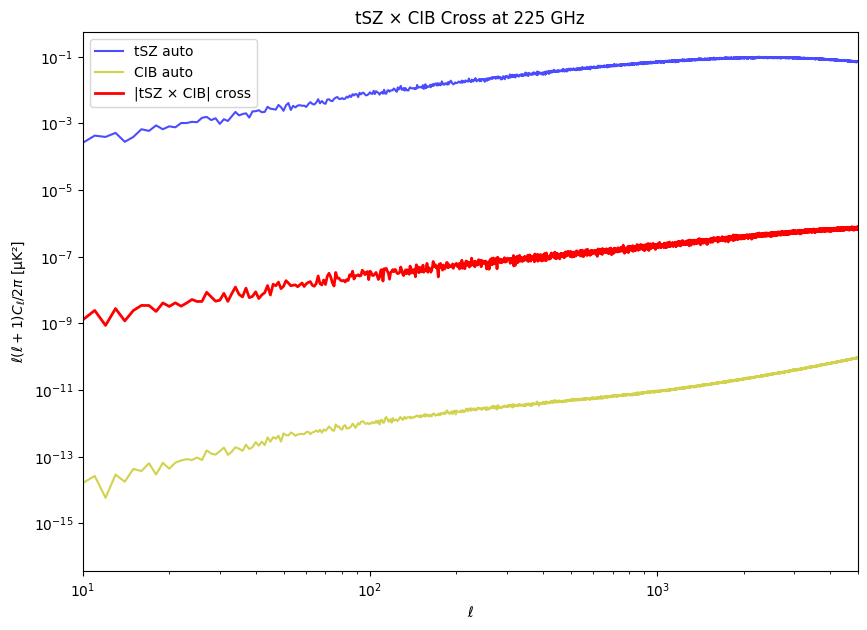

ρ at ℓ=3000: 0.287 (~28.7%)


In [24]:
print("\n" + "="*70)
print("PLOTTING")
print("="*70)

plt.figure(figsize=(10,7))
plt.loglog(ell[2:], Dl_tsz[2:], 'b-', label='tSZ auto', alpha=0.7)
plt.loglog(ell[2:], Dl_cib[2:], 'y-', label='CIB auto', alpha=0.7)
plt.loglog(ell[2:], np.abs(Dl_cross[2:]), 'r-', lw=2, label='|tSZ × CIB| cross')

plt.xlim(10, lmax)
#plt.ylim(1e-5, 1e3)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell(\ell+1) C_\ell / 2\pi$ [µK²]')
plt.title('tSZ × CIB Cross at 225 GHz')
#plt.grid(True, alpha=0.3);
plt.legend()
p = os.path.join(out_dir, "cross_power.png")
plt.savefig(p, dpi=200, bbox_inches='tight')
plt.show()

# Correlation coefficient
rho = cl_cross / np.sqrt(cl_tsz * cl_cib)
rho_3000 = rho[3000] if lmax >= 3000 else np.nan
print(f"ρ at ℓ=3000: {rho_3000:.3f} (~{rho_3000*100:.1f}%)")

In [22]:
print("\n" + "="*70)
print("SAVING")
print("="*70)

np.savetxt(os.path.join(out_dir, "cl_cross.txt"),
           np.column_stack([ell, cl_cross, Dl_cross, rho]),
           header='ell  C_ell_cross  D_ell_cross  rho', fmt='%.6e')

print("All done! Check output folder.")


SAVING
All done! Check output folder.
